In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sym
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import splrep, BSpline

In [2]:
df = pd.read_csv('gs://ggf-eth-data/unprocessed_ethereum_2018_2020')
df.head(3)

,from_address,to_address,value,gas_value,count
0,0x12df6b56e365f42bb38a885895819a8bcdb8bff8,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,408.608386,1.036399,51
1,0xea2acf1b8a181e8a0f1aa40384d1ddaf096232aa,0x025a9bc3ea7fc8a49704451f61b5ee1eaf488850,2.658300,0.045066,50
2,0x455f011790046a920b5b505cd9188d3c2077d4e4,0x7b7d4a8ee76755d453042dfc05787e464f765638,45.203273,0.052132,59


In [4]:
df['avg'] = df['value']/df['count']
df.head()

,from_address,to_address,value,gas_value,count,avg
0,0x12df6b56e365f42bb38a885895819a8bcdb8bff8,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,408.608386,1.036399,51,8.011929
1,0xea2acf1b8a181e8a0f1aa40384d1ddaf096232aa,0x025a9bc3ea7fc8a49704451f61b5ee1eaf488850,2.658300,0.045066,50,0.053166
2,0x455f011790046a920b5b505cd9188d3c2077d4e4,0x7b7d4a8ee76755d453042dfc05787e464f765638,45.203273,0.052132,59,0.766157
3,0xd06cd3d829e67ad3455d5035b071813625b0de6b,0x0424b365094898eaa2d64d13f26cd9aaf220cf6c,0.018225,0.123154,74,0.000246
4,0x69b71b9459e6ebde14a1b337a3720487aec111d4,0x1f39cc033edcac7e2a4f356aec55bee7f1cfdb34,0.859125,0.025099,174,0.004938


In [3]:
df.shape

(2178388, 5)

In [4]:
out_degree = df.groupby('from_address').from_address.count().to_frame('count').reset_index()
out_degree['count'].describe()

count    898376.000000
mean          2.424807
std         252.131787
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      210132.000000
Name: count, dtype: float64

In [5]:
in_degree = df.groupby('to_address').to_address.count().to_frame('count').reset_index()
in_degree['count'].describe()

count    1.035417e+06
mean     2.103744e+00
std      1.530873e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.191600e+05
Name: count, dtype: float64

Text(0.5, 0, 'Ingoing degree')

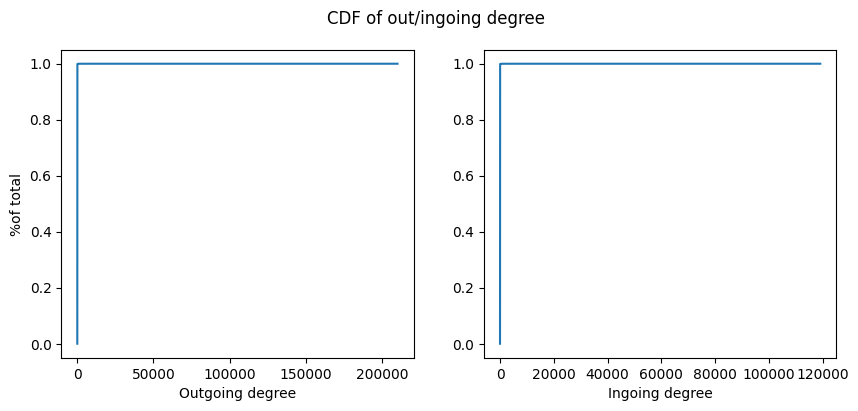

In [6]:
n_out = len(out_degree['count'])
x_out = np.sort(out_degree['count'])
y_out = np.arange(n_out) / float(n_out)

n_in = len(in_degree['count'])
x_in = np.sort(in_degree['count'])
y_in = np.arange(n_in) / float(n_in)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('CDF of out/ingoing degree')

ax1.plot(x_out, y_out)
ax1.set_xlabel('Outgoing degree')
ax1.set_ylabel('%of total')

ax2.plot(x_in, y_in)
ax2.set_xlabel('Ingoing degree')

In [8]:
# filter the dataset
df_filtered = df
while True:
    # filter based on outgoing degree
    out_degree_filtered = df_filtered.groupby('from_address').from_address.count().to_frame('count').reset_index()
    excl_out = out_degree_filtered.loc[out_degree_filtered['count'] <= 3]['from_address']
    df_filtered = df_filtered[~df_filtered['from_address'].isin(excl_out)]
    
    # filter based on in degree
    in_degree_filtered = df_filtered.groupby('to_address').to_address.count().to_frame('count').reset_index()
    excl_in = in_degree_filtered.loc[in_degree_filtered['count'] <= 3]['to_address']
    df_filtered = df_filtered[~df_filtered['to_address'].isin(excl_in)]
    
    if (len(excl_out) <= 0 and len(excl_in) <= 0):
        break

In [9]:
out_degree_filtered['count'].describe()

count    11204.000000
mean        12.085416
std         68.752578
min          4.000000
25%          4.000000
50%          5.000000
75%          8.000000
max       3222.000000
Name: count, dtype: float64

In [10]:
in_degree_filtered['count'].describe()

count    14360.000000
mean         9.428621
std         37.904178
min          4.000000
25%          4.000000
50%          5.000000
75%          7.000000
max       2571.000000
Name: count, dtype: float64

Text(0.5, 0, 'Ingoing degree')

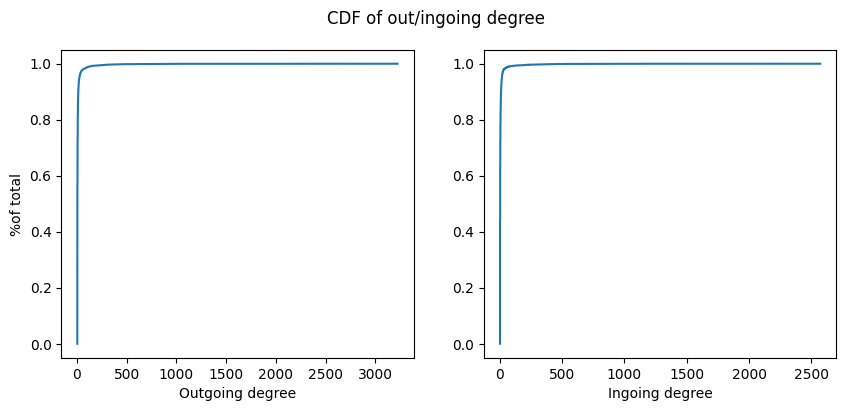

In [11]:
n_out = len(out_degree_filtered['count'])
x_out = np.sort(out_degree_filtered['count'])
y_out = np.arange(n_out) / float(n_out)

n_in = len(in_degree_filtered['count'])
x_in = np.sort(in_degree_filtered['count'])
y_in = np.arange(n_in) / float(n_in)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('CDF of out/ingoing degree')

ax1.plot(x_out, y_out)
ax1.set_xlabel('Outgoing degree')
ax1.set_ylabel('%of total')

ax2.plot(x_in, y_in)
ax2.set_xlabel('Ingoing degree')
plt.show()

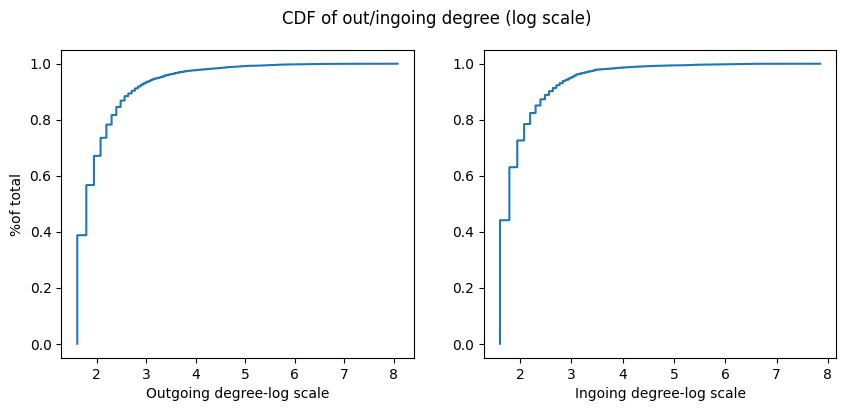

In [33]:
out_degree_filtered['count_log'] = np.log(out_degree_filtered['count']+1)
in_degree_filtered['count_log'] = np.log(in_degree_filtered['count']+1)

n_out = len(out_degree_filtered['count_log'])
x_out = np.sort(out_degree_filtered['count_log'])
y_out = np.arange(n_out) / float(n_out)

n_in = len(in_degree_filtered['count_log'])
x_in = np.sort(in_degree_filtered['count_log'])
y_in = np.arange(n_in) / float(n_in)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('CDF of out/ingoing degree (log scale)')

ax1.plot(x_out, y_out)
ax1.set_xlabel('Outgoing degree-log scale')
ax1.set_ylabel('%of total')

ax2.plot(x_in, y_in)
ax2.set_xlabel('Ingoing degree-log scale')
plt.show()


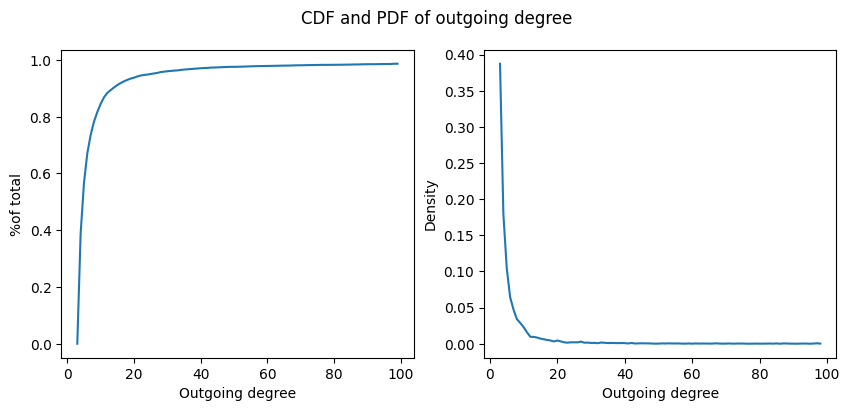

In [64]:
data = out_degree_filtered['count_log']
x = np.arange(3,100)
ecdf = ECDF(data)
cdf = ecdf(x)
dx = x[1]-x[0]
pdf = np.diff(cdf)/dx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('CDF and PDF of outgoing degree')

ax1.plot(x, cdf)
ax1.set_xlabel('Outgoing degree')
ax1.set_ylabel('%of total')

ax2.plot(x[:-1], pdf)
ax2.set_xlabel('Outgoing degree')
ax2.set_ylabel('Density')
plt.show()

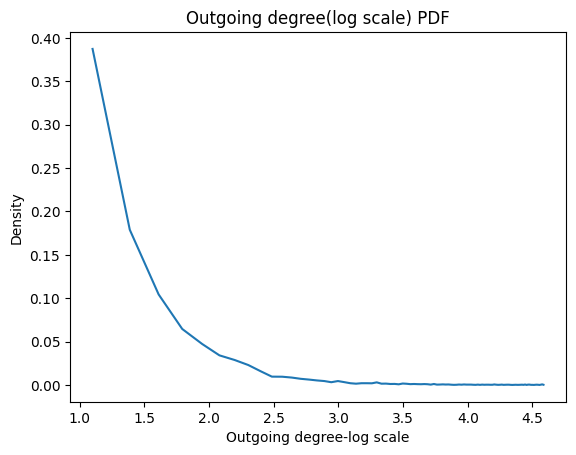

In [32]:
plt.plot(np.log(x[:-1]), pdf)
plt.title('Outgoing degree(log scale) PDF')
plt.xlabel('Outgoing degree-log scale')
plt.ylabel('Density')
plt.show()

In [152]:
out_degree['count_log'] = np.log(out_degree['count']+1)
out_degree['count_log'].describe()

count    18621.000000
mean         1.660509
std          0.718771
min          0.693147
25%          1.386294
50%          1.609438
75%          1.945910
max          8.095599
Name: count_log, dtype: float64

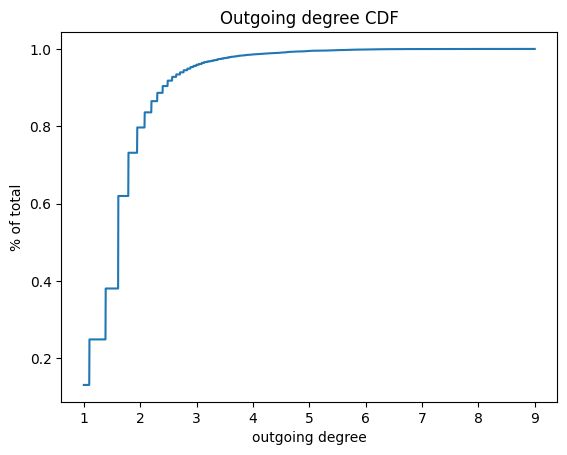

In [179]:
plt.plot(x, cdf)
plt.title('Outgoing degree CDF')
plt.xlabel('outgoing degree')
plt.ylabel('% of total')
plt.show()

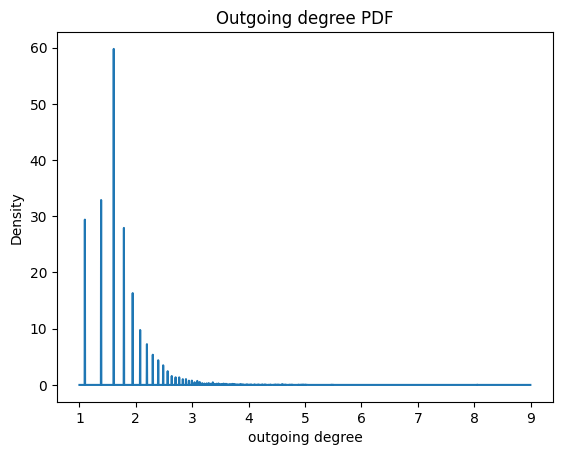

In [180]:
plt.plot(x[:-1], pdf)
plt.title('Outgoing degree PDF')
plt.xlabel('outgoing degree')
plt.ylabel('Density')
plt.show()

In [9]:
out_degree.loc[out_degree['count'] <= 3]['from_address']

0         0x0000000000000d9054f605ca65a2647c2b521422
1         0x0000000000004681cb5d63ec5098e869a637d9be
2         0x0000000000015bbe9a1bfe5ba28e16c69b40a58b
3         0x00000000000d7fb20c9708261ad2e0b03f15fa04
4         0x0000000000333f28d3a20605c702f66c3143cccf
                             ...                    
898370    0xffffe6c261fac5ea28c41e71672b482efbad8e4b
898372    0xfffffb89950b81305469740ebdb7641a134930c7
898373    0xfffffd033b8d25ee5eb63c818af8171775e91b8f
898374    0xfffffff1ac8dcf49f4afd3f90995120e568740f9
898375    0xffffffff37d2d839f3b4f7dbb9630463655fc04f
Name: from_address, Length: 874107, dtype: object

In [96]:
df.shape

(135405, 5)

In [97]:
out_degree['count_log'] = np.log(out_degree['count']+1)
in_degree['count_log'] = np.log(in_degree['count']+1)

In [99]:
out_degree['count_log'].describe()

count    11204.000000
mean         2.029671
std          0.648295
min          1.609438
25%          1.609438
50%          1.791759
75%          2.197225
max          8.078068
Name: count_log, dtype: float64

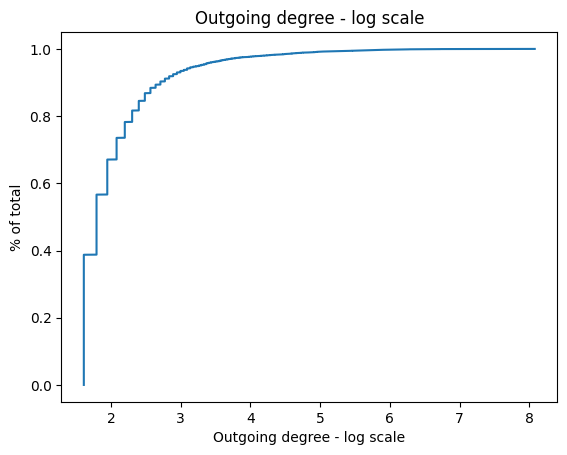

In [101]:
n = len(out_degree['count_log'])
x = np.sort(out_degree['count_log'])
y = np.arange(n) / float(n)

plt.xlabel('Outgoing degree - log scale')
plt.ylabel('% of total')
plt.title('CDF of outgoing degree in log scale')
plt.plot(x, y)

In [102]:
in_degree['count_log'].describe()

count    14360.000000
mean         1.954377
std          0.563231
min          1.609438
25%          1.609438
50%          1.791759
75%          2.079442
max          7.852439
Name: count_log, dtype: float64

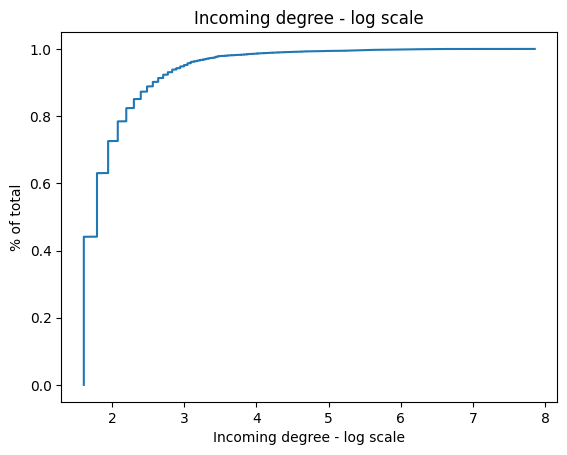

In [104]:
n = len(in_degree['count_log'])
x = np.sort(in_degree['count_log'])
y = np.arange(n) / float(n)

plt.xlabel('Incoming degree - log scale')
plt.ylabel('% of total')
plt.title('Incoming degree - log scale')
plt.plot(x, y)

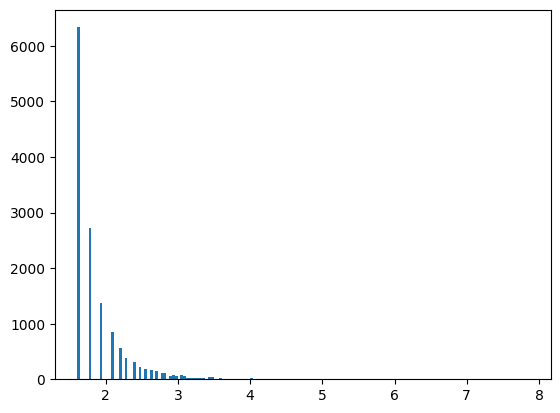

In [115]:
fig, ax = plt.subplots()
ax.hist(x, density=True, histtype='stepfilled', bins='auto');

In [105]:
raw_data = df.to_dict('records')

transaction_dict = {}
for row in raw_data:
    id_ = row['from_address']
    if id_ not in transaction_dict:
        transaction_dict[id_] = []
    
    value = row['value']
    transaction_dict[id_].append(value)

In [107]:
#transaction_dict

In [108]:
 {k:v for k, v in transaction_dict.items() if k == '0x65b435425e7928c594997f38681b542234be91d3'}

{'0x65b435425e7928c594997f38681b542234be91d3': [337.1064761351995,
  364.4,
  159.74804709763396,
  147.34288234647502,
  0.1900000000000001,
  21.245945014831527,
  16.274611750000002,
  1193.4504603732398,
  98.5,
  192.3,
  75.93,
  61.07]}